In [1]:
from nhrc_utils.new_cnn import segmentation_model 
from src.preprocess_and_save import do_preprocessing, big_specgram_process

LR_KERNEL_SIZE: 61


In [ ]:
# do_preprocessing(big_specgram_process)

In [6]:
import numpy as np
stationary = np.load('/Users/eric/Engineering/Work/pisces/examples/NHRC/pre_processed_data/stationary/stationary_preprocessed_data_50.npy', allow_pickle=True).item()
s0 = stationary['8173033']
s0_spec = s0['spectrogram']
s0_spec.shape

In [30]:
import matplotlib.pyplot as plt
def add_rgb_legend(ax):
    """
    Adds an RGB legend indicating the mapping of colors to accelerometer axes.
    """
    
    # Create a small color block with labels
    colors = ['red', 'green', 'blue']
    labels = ['X-axis (Red)', 'Y-axis (Green)', 'Z-axis (Blue)']
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((0, i), 1, 1, color=color))
        ax.text(1.2, i + 0.5, labels[i], va='center', fontsize=12)

    ax.axis('off')
    ax.set_xlim(0, 2)
    ax.set_ylim(-0.5, 3)

def overlay_channels_fixed(spectrogram_tensor, mintile=5, maxtile=95):
    """
    Overlay spectrogram channels as an RGB image by stacking the three axes (x, y, z).
    
    Parameters:
        spectrogram_tensor (numpy.ndarray): Spectrogram tensor of shape (time_bins, freq_bins, 3).
    """
    # Normalize each channel to [0, 1] for proper RGB visualization
    norm_spec = np.zeros_like(spectrogram_tensor)
    for i in range(3):
        channel = spectrogram_tensor[:, :, i]
        p5, p95 = np.percentile(channel, [mintile, maxtile])  # Robust range
        norm_spec[:, :, i] = np.clip((channel - p5) / (p95 - p5 + 1e-8), 0, 1)  # Avoid dividing by zero
    
    # Display the combined RGB image
    plt.figure(figsize=(10, 5))
    plt.imshow(norm_spec, aspect='auto', origin='lower')
    # add_rgb_legend(plt.gca())
    # plt.colorbar(label='Intensity')
    plt.xlabel('Time Bins')
    plt.ylabel('Frequency Bins')
    plt.title('Overlayed Spectrogram Channels as RGB')
    plt.show()


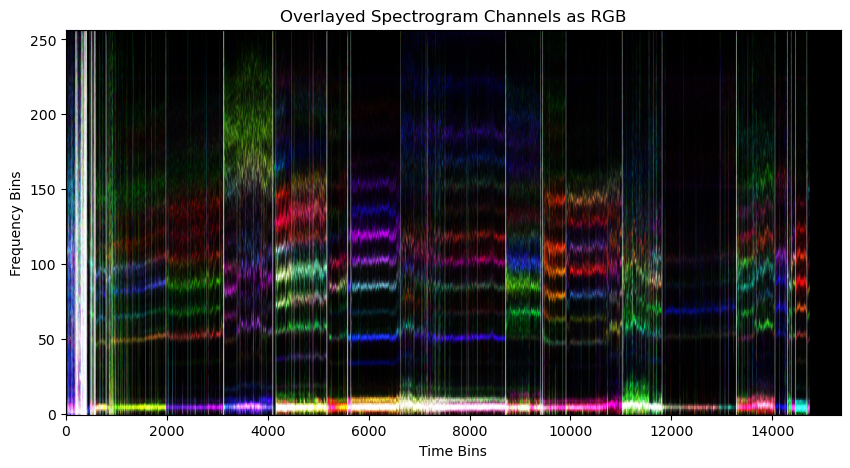

In [31]:
overlay_channels_fixed(np.swapaxes(s0_spec, 0, 1))

In [17]:
def debug_normalization(spectrogram_tensor):
    for i in range(3):
        channel = spectrogram_tensor[:, :, i]
        print(f"Channel {i} - Min: {channel.min()}, Max: {channel.max()}, Mean: {channel.mean()}")

debug_normalization(s0_spec)

Channel 0 - Min: 0.0, Max: 2.2004356455616763, Mean: 0.00011417207660600776
Channel 1 - Min: 0.0, Max: 2.6464025679623195, Mean: 0.00015659879832374132
Channel 2 - Min: 0.0, Max: 3.7830375680285755, Mean: 0.00013415282057880113


In [32]:
import numpy as np
hybrid = np.load('/Users/eric/Engineering/Work/pisces/examples/NHRC/pre_processed_data/hybrid/hybrid_preprocessed_data_50.npy', allow_pickle=True).item()
h0 = hybrid['8173033']
h0_spec = h0['spectrogram']
h0_spec.shape

(15360, 257, 3)

In [33]:
debug_normalization(h0_spec)

Channel 0 - Min: 0.0, Max: 2.2468234760907215, Mean: 0.00012686104033472428
Channel 1 - Min: 0.0, Max: 2.6070787011652157, Mean: 0.0002670292145178993
Channel 2 - Min: 0.0, Max: 3.8281839227968115, Mean: 0.00018305094360102528


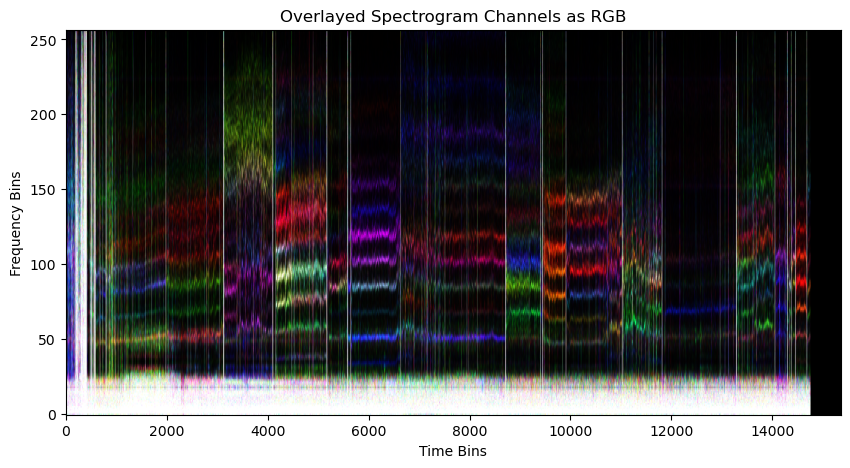

In [42]:
overlay_channels_fixed(np.swapaxes(h0_spec, 0, 1), mintile=5, maxtile=89)

# Explore the model definition
This is for the grizzly part where we repeatedly fail to call the model on our specgrams, then eventually get it right.

In [48]:
import tensorflow as tf
from keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
)
from keras.models import Model

from examples.NHRC.nhrc_utils.new_cnn import NEW_INPUT_SHAPE

def segmentation_model(input_shape=NEW_INPUT_SHAPE, num_classes=4):
    inputs = Input(shape=input_shape)
    
    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)  # Downsampling
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)  # Further Downsampling
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)  # Bottleneck
    
    # Decoder
    u1 = UpSampling2D((2, 2))(p3)
    u1 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Concatenate()([u1, c3])  # Skip connection
    
    u2 = UpSampling2D((2, 2))(u1)
    u2 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Concatenate()([u2, c2])  # Skip connection
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(u2)  # Class scores per pixel
    
    model = Model(inputs, outputs)
    return model

In [49]:
seg = segmentation_model()

In [51]:

seg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 15360,     │          0 │ -                 │
│ (InputLayer)        │ 257, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 15360,     │      1,792 │ input_layer_3[0]… │
│                     │ 257, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15360,     │        256 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 257, 64)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 7680, 128, │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 7680, 128, │     73,856 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7680, 128, │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 3840, 64,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 3840, 64,  │    295,168 │ max_pooling2d_10… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3840, 64,  │      1,024 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 1920, 32,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 3840, 64,  │          0 │ max_pooling2d_11… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 3840, 64,  │    295,040 │ up_sampling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3840, 64,  │        512 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 3840, 64,  │          0 │ batch_normalizat… │
│ (Concatenate)       │ 384)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_5     │ (None, 7680, 128, │          0 │ concatenate_4[0]… │
│ (UpSampling2D)      │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 7680, 128, │    221,248 │ up_sampling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7680, 128, │        256 │ conv2d_17[0][0] 

 Total params: 890,436 (3.40 MB)

 Trainable params: 889,156 (3.39 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [53]:
seg.compile(optimizer='adamw', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [57]:
s0_spec.shape

(15360, 257, 3)

In [61]:
s0_spec_batch = np.expand_dims(s0_spec, axis=0)  # Shape: (1, 15360, 257, 3)

s0_eval = seg.predict(s0_spec_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [62]:
s0_eval.shape

(1, 7680, 128, 4)